# P5: Deep RL, Bandits & MCTS

[Instructions are the same as they have been. You know the drill by now.]


## P5.1 Deep Reinforcement Learning

In the last programming assignment, you were asked to implement Q learning. Since then, we've discussed *Deep Reinforcement Learning*, in which deep learning is used to learn to approximate the Q function. While deep learning is somewhat out of scope for this class, I thought it would be instructive for you to follow a tutorial for Deep RL and tune the parameters a bit. The following link takes you to a Google Collab notebook, which lets you connect to a (free, with a Google account) cloud GPU on which the experiments will be run:

https://colab.research.google.com/github/tensorflow/agents/blob/master/docs/tutorials/1_dqn_tutorial.ipynb

We will be experimenting with the 'cartpole' environment, in which an agent seeks to move a cart so as to balance a pole vertically upwards. The agent is rewarded for each time step in which the pole is vertical. This is a common environment for debugging and evaluating reinforcement learning algorithms.

**QUESTION** For this scenario, what is the maximum total reward for the Cartpole problem (this is written out in the tutorial notebook)?

**TASK** Run all the tutorial code without modification. [Navigate to "Runtime" in the menu bar and then "Run all".]

**RESULT** Before the machine learning algorithm is trained, the function `compute_avg_return` is used to evaluate the performance of a random policy. Include in your report the value of that random policy.

**PLOT** After the code is complete, it will generate a plot of "Average Return vs. Iterations". Include this plot in your writeup.

**QUESTION** How does the algorithm perform? How does the final average return compare to the maximum possible value?

**TASK/PLOT** Under the "Hyperparameters" section, there are a few parameters you can tune. Next, we will change the `learning_rate` (initially set to `1e-3`), which controls the rate at which the parameters of the neural network that estimates Q are tuned. Rerun all the code (via "Run all") for `learning_rate` set to `1e-4`). Include the *clearly labeled* plot of Average Return vs. Iterations.

**QUESTION** (3-6 sentences) Describe how the learning rate changes performance. Does the final average return change? Does the rate of improvement change?

## P5.2 Bandit Algorithms

Here, you'll be looking in more depth at the Bandit Algorithms we discussed in class. To begin, you are given the same example we saw in the in-class breakout session. You are provided with 10 bandits of an unknown (to the agent) reward distribution. The plot generated in the first plot shows the rewards generated by "pulling" the arms of each bandit.

### P5.2.1 Epsilon Greedy Bandits

I have given you starter code for the epsilon-greedy bandit algorithm we discussed in class.

**TASK** Complete `bandit_epsilon_greedy` and run the evaluation code that follows.

**PLOTS** Include the set of plots (in a single figure) generated by the evaluation code.

**RESULTS** Include in your report the (average) percentage of optimal pulls for each value of epsilon.

**QUESTION** (2-4 sentences) For which epsilon is the peak "optimal pull percentage"? Why does the percentage of optimal pulls (and, relatedly the average reward) decrease for the higher values of epsilon?

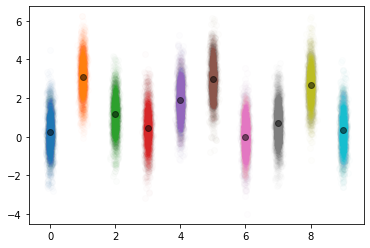

In [7]:
# N-armed bandit
import random
import numpy as np
import matplotlib.pyplot as plt
random.seed(695)

# Generate some bandits
class Bandit(object):
    def __init__(self, mean=None, mean_range=[-1, 3], sigma=1.0):
        if mean is None:
            self.mean = random.uniform(min(mean_range), max(mean_range))
        else:
            self.mean = mean
        self.mean_range = mean_range
        self.sigma = sigma
        
    def pull_arm(self):
        return random.gauss(self.mean, self.sigma)
    
    def get_data_for_plot(self, width=0.05, num_values=2000):
        xs = np.random.normal(0, width, num_values)
        ys = np.random.normal(self.mean, self.sigma, num_values)
        return xs, ys

def plot_bandits(bandits):
    for ii, bandit in enumerate(bandits):
        xs, ys = bandit.get_data_for_plot()
        plt.scatter(xs + ii, ys, alpha=0.01)
        plt.plot(ii, bandit.mean, 'ko', alpha=0.5)
    
num_bandits = 10
bandits = [Bandit() for _ in range(8)]
bandits.append(Bandit(mean=3.0))
bandits.append(Bandit(mean=3.1))
random.shuffle(bandits)
plot_bandits(bandits)

In [8]:
random.random()

0.2708608883197461

In [12]:
## Bandit starter code

def bandit_epsilon_greedy(bandits, num_steps=2000, epsilon=0.0, seed=695):
    """
    returns (average reward over time,
             proportion of pulls for each bandit by end)
    """
    random.seed(seed)
    num_pulls_per_bandit = np.zeros(len(bandits))
    tot_reward_per_bandit = np.zeros(len(bandits))
    all_rewards = []  # List of each reward returned per pull.
    
    for ii in range(num_steps):
        # Pick one of the bandits
        if random.random() > epsilon:
            Q = np.zeros(len(bandits))
            for jj in range(len(bandits)):
                if num_pulls_per_bandit[jj] ==0:
                    n_visit = 1
                else:
                    n_visit = num_pulls_per_bandit[jj]
                Q[jj] = tot_reward_per_bandit[jj]/n_visit
            bandit_ind = np.argmax(Q)
        else:
            bandit_ind = random.randint(0, len(bandits)-1)

        # Data Storage
        reward = bandits[bandit_ind].pull_arm()
        tot_reward_per_bandit[bandit_ind] += reward
        num_pulls_per_bandit[bandit_ind] += 1
        all_rewards.append(reward)
    
    return (np.cumsum(all_rewards) / (np.arange(num_steps) + 1),
            num_pulls_per_bandit / num_steps)

Eps = 0.001 : Optimal Pulls =  78.59%
Eps = 0.050 : Optimal Pulls =  84.60%
Eps = 0.100 : Optimal Pulls =  75.75%
Eps = 0.200 : Optimal Pulls =  64.00%
Eps = 0.500 : Optimal Pulls =  45.12%


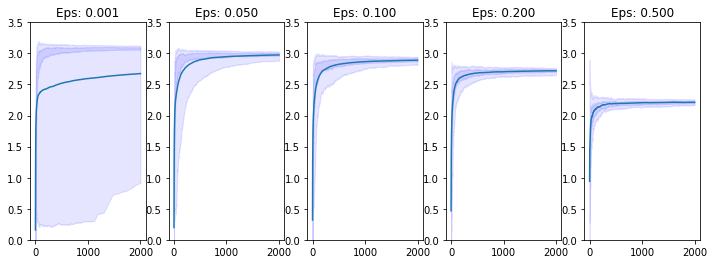

In [14]:
# Plotting Code
plt.figure(figsize=(12, 4))
epsilons = [0.001, 0.05, 0.1, 0.2, 0.5]
best_bandit_ind = bandits.index(max(bandits, key=lambda b: b.mean))
for ii, epsilon in enumerate(epsilons):
    dat = [bandit_epsilon_greedy(bandits, epsilon=epsilon, seed=seed)
                for seed in range(100)]
    all_runs, pull_rates = zip(*dat)
    plt.subplot(1, len(epsilons), ii+1)
    avg_rewards = np.mean(all_runs, axis=0)
    p10_rewards = np.percentile(all_runs, 10, axis=0)
    p30_rewards = np.percentile(all_runs, 30, axis=0)
    p70_rewards = np.percentile(all_runs, 70, axis=0)
    p90_rewards = np.percentile(all_runs, 90, axis=0)
    plt.plot(avg_rewards)
    plt.fill_between(range(len(avg_rewards)),
                     p30_rewards,
                     p70_rewards,
                     alpha=0.1, color='blue')
    plt.fill_between(range(len(avg_rewards)),
                     p10_rewards,
                     p90_rewards,
                     alpha=0.1, color='blue')
    print(f"Eps = {epsilon:0.3f} : Optimal Pulls = "
          f"{100*np.mean(pull_rates, axis=0)[best_bandit_ind]:6.2f}%")
    plt.title(f"Eps: {epsilon:0.3f}")
    plt.ylim([0, 3.5])

### P5.2.2 UCB Bandits

**TASK** Implement the UCB Bandit function `bandit_ucb(bandits, num_steps=2000, c=4.0, seed=695)` and run the evaluation code that follows. Your `bandit_ucb` implementation will look a lot like the `bandit_epsilon_greedy`, so you may use that as starter code.

**CODE** Include your implementation of `bandit_ucb` in your writeup.

**PLOTS** Include the set of plots (in a single figure) generated by the evaluation code.

**RESULTS** Include in your report the (average) percentage of optimal pulls for each value of C (the exploration parameter).

**QUESTION** (2-5 sentences) For which C is the peak "optimal pull percentage"? How does the percentage of optimal pulls for this value of C compare to the best epsilon from the epsilon-greedy bandit? Why?

**QUESTION** (2-5 sentences) Why is the average performance of the algorithm poor for very low values of C? What will happen to the performance as the number of trials approach infinity?

**QUESTION** (2-5 sentences) Why is the average performance of the algorithm poor for very high values of C? What will happen to the performance as the number of trials approach infinity?

In [5]:
## Bandit starter code

def bandit_ucb(bandits, num_steps=2000, c=4.0, seed=695):
    """
    returns (average reward over time,
             proportion of pulls for each bandit by end)
    """
    random.seed(seed)
    num_pulls_per_bandit = np.zeros(len(bandits))
    tot_reward_per_bandit = np.zeros(len(bandits))
    all_rewards = []  # List of each reward returned per pull.
    
    for ii in range(num_steps):
        # Pick one of the bandits by ucb
        ucb = np.zeros(len(bandits))
        for jj in range(len(bandits)):
          if num_pulls_per_bandit[jj] ==0:
             n_visit = 1
          else:
              n_visit = num_pulls_per_bandit[jj]
          
          ucb[jj] = tot_reward_per_bandit[jj]/n_visit + \
                           np.sqrt(c*np.log(ii+1)/n_visit)
        bandit_ind = np.argmax(ucb)

        # Data Storage
        reward = bandits[bandit_ind].pull_arm()
        tot_reward_per_bandit[bandit_ind] += reward
        num_pulls_per_bandit[bandit_ind] += 1
        all_rewards.append(reward)
    
    return (np.cumsum(all_rewards) / (np.arange(num_steps) + 1),
            num_pulls_per_bandit / num_steps)

c = 0.00001 : Optimal Pulls =  73.86%
c = 0.00010 : Optimal Pulls =  73.86%
c = 0.00100 : Optimal Pulls =  79.82%
c = 0.01000 : Optimal Pulls =  98.05%
c = 0.10000 : Optimal Pulls =  99.73%
c = 1.00000 : Optimal Pulls =  99.87%
c = 10.00000 : Optimal Pulls =  57.15%


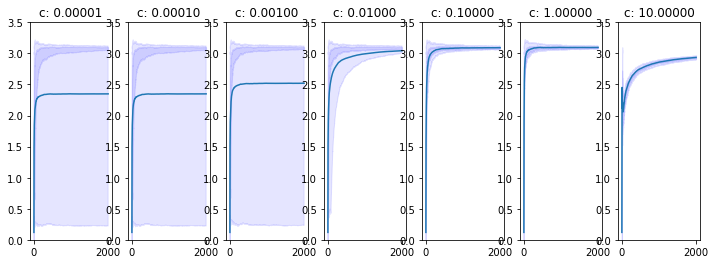

In [6]:
# Plotting Code
plt.figure(figsize=(12, 4))
cs = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1]
best_bandit_ind = bandits.index(max(bandits, key=lambda b: b.mean))
for ii, c in enumerate(cs):
    dat = [bandit_ucb(bandits, c=c, seed=seed)
           for seed in range(100)]
    all_runs, pull_rates = zip(*dat)
    plt.subplot(1, len(cs), ii+1)
    avg_rewards = np.mean(all_runs, axis=0)
    p10_rewards = np.percentile(all_runs, 10, axis=0)
    p30_rewards = np.percentile(all_runs, 30, axis=0)
    p70_rewards = np.percentile(all_runs, 70, axis=0)
    p90_rewards = np.percentile(all_runs, 90, axis=0)
    plt.plot(avg_rewards)
    plt.fill_between(range(len(avg_rewards)),
                     p30_rewards,
                     p70_rewards,
                     alpha=0.1, color='blue')
    plt.fill_between(range(len(avg_rewards)),
                     p10_rewards,
                     p90_rewards,
                     alpha=0.1, color='blue')
    print(f"c = {c:0.5f} : Optimal Pulls = "
          f"{100*np.mean(pull_rates, axis=0)[best_bandit_ind]:6.2f}%")
    plt.title(f"c: {c:0.5f}")
    plt.ylim([0, 3.5])

## P5.3 Connect Four and MCTS

I have provided you with a (pure python) implementation of the popular turn-based game "Connect Four". In this game, you 'drop' pieces of different color into the game board, trying to get four in a row (along any axis) before your opponent can. In this question, I have provided you with an implementation of minimax search, which you will use to compare against your own implementation of Monte Carlo Tree Search.

### P5.3.1 Minimax

I have provided you with an already-complete minimax algorithm implementation. The algorithm has an element of randomness in it: if it multiple actions are of equal value, it picks one at random. The evaluation code below pits two different minimax algorithms against one another: one that runs at depth 5 and one that runs at depth 3.

**QUESTION** (2-3 sentences) What is the evaluation function being used to evaluate the goodness of a board state once the maximum depth is reached? How "useful" is the value function I have provided?

**TASK** Run the evaluation code below and observe the results.

**RESULTS** Include the win/draw counts in your writeup.

**QUESTION** (1-3 sentences) You may notice that sometimes the depth-3 minimax search wins against the depth-5 minimax search. How is this possible?

In [ ]:
# Connect Four Implementation
import copy
import numpy as np
import random


class ConnectFourBoard(object):
    def __init__(self, nrows=6, ncols=7):
        self.current_player = 1
        self.nrows = nrows
        self.ncols = ncols
        self.board = np.zeros((nrows, ncols), int)
        self.winner = None

    def get_moves(self):
        return np.where(self.board[0] == 0)[0]

    def _check_winner(self, row, col):
        """Check if the move in col ended the game.
        Not wonderful code, but easy to follow and debug."""
        b, r, c = self.board, row, col
        
        # Diagonal 1
        if r - 3 >= 0 and c - 3 >= 0:
            if b[r, c] == b[r-1, c-1] == b[r-2, c-2] == b[r-3, c-3]:
                self.winner = b[r, c]
                return
        if r - 2 >= 0 and c - 2 >= 0 and r + 1 < self.nrows and c + 1 < self.ncols:
            if b[r+1, c+1] == b[r, c] == b[r-1, c-1] == b[r-2, c-2]:
                self.winner = b[r, c]
                return
        if r - 1 >= 0 and c - 1 >= 0 and r + 2 < self.nrows and c + 2 < self.ncols:
            if b[r+2, c+2] == b[r+1, c+1] == b[r, c] == b[r-1, c-1]:
                self.winner = b[r, c]
                return
        if r + 3 < self.nrows and c + 3 < self.ncols:
            if b[r+3, c+3] == b[r+2, c+2] == b[r+1, c+1] == b[r, c]:
                self.winner = b[r, c]
                return
                
        # Diagonal 2
        if r - 3 >= 0 and c + 3 < self.ncols:
            if b[r, c] == b[r-1, c+1] == b[r-2, c+2] == b[r-3, c+3]:
                self.winner = b[r, c]
                return
        if r - 2 >= 0 and c + 2 < self.ncols and r + 1 < self.nrows and c - 1 >= 0:
            if b[r+1, c-1] == b[r, c] == b[r-1, c+1] == b[r-2, c+2]:
                self.winner = b[r, c]
                return
        if r - 1 >= 0 and c + 1 < self.ncols and r + 2 < self.nrows and c - 2 >= 0:
            if b[r+2, c-2] == b[r+1, c-1] == b[r, c] == b[r-1, c+1]:
                self.winner = b[r, c]
                return
        if r + 3 < self.nrows and c - 3 >= 0:
            if b[r+3, c-3] == b[r+2, c-2] == b[r+1, c-1] == b[r, c]:
                self.winner = b[r, c]
                return
                
        # Flat
        if c + 3 < self.ncols:
            if b[r, c] == b[r, c+1] == b[r, c+2] == b[r, c+3]:
                self.winner = b[r, c]
                return
        if c + 2 < self.ncols and c - 1 >= 0:
            if b[r, c-1] == b[r, c] == b[r, c+1] == b[r, c+2]:
                self.winner = b[r, c]
                return
        if c + 1 < self.ncols and c - 2 >= 0:
            if b[r, c-2] == b[r, c-1] == b[r, c] == b[r, c+1]:
                self.winner = b[r, c]
                return
        if c - 3 >= 0:
            if b[r, c-3] == b[r, c-2] == b[r, c-1] == b[r, c]:
                self.winner = b[r, c]
                return
                
        # Down
        if r - 3 >= 0:
            if b[r, c] == b[r-1, c] == b[r-2, c] == b[r-3, c]:
                self.winner = b[r, c]
                return
        if r + 3 < self.nrows:
            if b[r+3, c] == b[r+2, c] == b[r+1, c] == b[r, c]:
                self.winner = b[r, c]
                return

    def copy(self):
        return copy.deepcopy(self)

    def play_move(self, col):
        try:
            row = np.where(self.board[:, col] == 0)[0][-1]
        except IndexError:
            raise ValueError(f"Cannot play column '{col}'.")
        self.board[row, col] = self.current_player

        # Check for a winner
        self._check_winner(row, col)
        
        # Check if no more moves
        if len(self.get_moves()) == 0:
            self.winner = 0
        
        # Switch player
        if self.current_player == 1:
            self.current_player = 2
        else:
            self.current_player = 1
        
        return self
            
    def play_random_move(self):
        self.play_move(random.choice(self.get_moves()))
    
    def play_random_moves_until_done(self):
        while self.winner is None:
            self.play_random_move()

        return self.winner
            
    def __str__(self):
        string = ''
        print()
        for row in self.board:
            string += f"|{row}|\n"
        string += '=' * (2 * self.ncols + 3)
        
        return string
    
# Some simple tests
print("A board and randomly playing moves.")
board = ConnectFourBoard(nrows=6, ncols=7)
print(board)
print(board.get_moves())

while board.winner is None:
    board.play_random_move()

print(board)
print(board.winner)
print(board.get_moves())


In [3]:
# Minimax search
def minimax(state, depth, is_max_turn=True, is_start=True, player=None, verbose=False):
    if player is None:
        player = state.current_player
    if depth == 0 or state.winner is not None:
        if state.winner is None or state.winner == 0:
            return 0
        else:
            return 2 * (state.winner == player) - 1

    moves = state.get_moves()
    values = [minimax(state.copy().play_move(move), depth - 1, not is_max_turn, 
                      is_start=False, player=player)
              for move in moves]
    # print(values)

    if is_start:
        # get the item whose values are maximum 
        best_actions = np.where(np.array(values) == max(values))[0]
        action_ind = random.choice(best_actions)
        if verbose:
            print(list(zip(values, moves)), action_ind)
        return moves[action_ind]
    if is_max_turn:
        return max(values)
    else:
        return min(values)

In [ ]:
# minimax evaluation code

def print_wins_minimax(wins):
    print("======")
    print(f"Total Plays: {len(wins)}")
    print(f"Depth 6 Wins: {len([w for w in wins if w == 1])}")
    print(f"Depth 4 Wins: {len([w for w in wins if w == 2])}")
    print(f"Draws: {len([w for w in wins if w == 0])}")


wins = []
for _ in range(25):
    board = ConnectFourBoard(nrows=6, ncols=7)
    board.current_player = random.choice([1, 2])
    print("the player play first: ", board.current_player)
    while board.winner is None:
        if board.current_player == 1:
            action = minimax(board, depth=5)
        else:
            action = minimax(board, depth=3)
        board.play_move(action)
    
    print(board)
    print(board.winner)
    wins.append(board.winner)
    print_wins_minimax(wins)

### P5.3.2 Monte-Carlo Tree Search [8 points]

*Note: regardless of which algorithm goes first, MCTS is always represented by the number '2' in the printed out board states and minimax is always '1'*

**TASK** Complete the functions `monte_carlo_tree_search`, `backpropagate`, `best_child`, and `best_uct`.

**CODE** Include your implementations of `monte_carlo_tree_search`, `backpropagate`, `best_child`, and `best_uct` in your writeup.

**TASK** Run the evaluation code below. (Note that it may take a few minutes to run all 25 games.)

**QUESTION+RESULTS+PLOTS** For the given configuration (1000 iterations, C=5), which algorithm wins more often? Pick a couple final board states (printed out when one strategy wins) and include them in your writeup (screenshots are acceptable).

**QUESTION+RESULTS** Rerun the experiments with C=0.1 and C=25. Include the win rates; how well does MCTS perform when you change C?

**QUESTION+PLOTS** (4-5 sentences) Describe how the behavior of the MCTS changes when you change the value of C. Pick a couple final board states (printed out when one strategy wins) that support your conclusion and include them in your writeup (screenshots are acceptable). In your answer, you might consider discussing the types of ways MCTS wins/loses for different values of C. Be sure to label which value of C was used for each final board state you include in your writeup.

In [20]:
# Starter Code: MCTS Implementation
import time


class Tree():
    def __init__(self, *, start_state=None, parent=None, move=None):
        if parent is None:
            self.parent = None
            self.move = None
            self.state = start_state
        else:
            self.parent = parent
            self.move = move
            self.state = parent.state.copy()
            self.state.play_move(move)
        
        self.values = [] # the values for the action sets
        self.n = 0      # the number of visit in this node
        if self.is_terminal_state:
            self.unexplored_moves = set()
        else:
            self.unexplored_moves = set(self.state.get_moves())
        self.children = set([])
            
    @property
    def fully_expanded(self):
        return len(self.unexplored_moves) == 0
    
    @property
    def is_terminal_state(self):
        return (self.state.winner is not None)


def monte_carlo_tree_search(start_state, num_iterations=1000):
    """MCTS core loop"""
    # Start by creating the root of the tree.
    root = Tree(start_state=start_state)
    if len(root.values) == 0:
        for jj in range(len(root.state.get_moves())):
            root.values.append(0.0)
    # Loop through MCTS iterations.
    for _ in range(num_iterations):
        # One step of MCTS iteration
        leaf = traverse(root)
        if len(leaf.values) == 0:
            for jj in range(len(leaf.state.get_moves())):
                leaf.values.append(0.0) 
        simulation_result = rollout(leaf, root.state)
        backpropagate(leaf, simulation_result)

        # raise NotImplementedError()

    # When done iterating, return the 'best' child of the root node.
    return best_child(root)

def best_child(node):
    """When done sampling, pick the child visited the most."""
    best_action = None
    max_visit = 0
    for child in node.children:
        if child.n > max_visit:
            max_visit = child.n
            best_action = child.move
    return best_action
    

def best_uct(node, C=25):
    """Pick the best action according to the UCB/UCT algorithm"""

    ucb = np.zeros(len(node.values))
    moves = node.state.get_moves()
    for jj in range(len(node.values)):
        for child in node.children:
            if child.move == moves[jj]:
                n_visit = child.n
        ucb[jj] = node.values[jj]/n_visit + \
                        np.sqrt(C*np.log(node.n+1)/n_visit)
    action = moves[np.argmax(ucb)]
    for child in node.children:
        if action == child.move:
            return child
    # raise NotImplementedError()

def traverse(node):
    # If fully explored, pick one of the children
    while node.fully_expanded and not node.is_terminal_state:
        node = best_uct(node)
    # If the node is terminal, return it
    if node.is_terminal_state:
        return node
    
    # If the node is not terminal:
    # 1. pick a new move from 'unexplored_moves'
    move = node.unexplored_moves.pop()
    # 2. create a new child
    new_child = Tree(parent=node, move=move)
    # 3. add that child to the list of children
    node.children.add(new_child)
    # 4. return that new child
    return new_child


def rollout(node, start_state):
    winner = node.state.copy().play_random_moves_until_done()
    if winner == 0:
        return 0
    elif winner == start_state.current_player:
        return 1
    else:
        return -1


def backpropagate(node, simulation_result):
    """Update the node and its parent (via recursion)."""
    if node is None:
        return
    node.n += 1
    if node.parent is not None:
      actions = node.parent.state.get_moves()
      for ii in range(len(actions)):
        if actions[ii] == node.move:
          node.parent.values[ii] += simulation_result
    backpropagate(node.parent, simulation_result)
    # raise NotImplementedError()

In [21]:
# Evaluation Code

def print_wins(wins):
    print("======")
    print(f"Total Plays: {len(wins)}")
    print(f"MiniMax Wins: {len([w for w in wins if w == 1])}")
    print(f"MCTS Wins: {len([w for w in wins if w == 2])}")
    print(f"Draws: {len([w for w in wins if w == 0])}")

wins = []
for _ in range(25):
    tot_time_minimax = 0
    tot_time_mcts = 0
    board = ConnectFourBoard(nrows=6, ncols=7)
    board.current_player = random.choice([1, 2])
    while board.winner is None:
        if board.current_player == 1:
            stime = time.time()
            action = minimax(board, depth=5, verbose=False)
            tot_time_minimax += time.time() - stime
        else:
            stime = time.time()
            action = monte_carlo_tree_search(board)
            tot_time_mcts += time.time() - stime
        board.play_move(action)
    
    print(board)
    print(f"Winner: {board.winner}")
    print(tot_time_minimax, tot_time_mcts)
    wins.append(board.winner)
    print_wins(wins)


|[0 0 0 1 0 0 0]|
|[0 0 2 2 0 0 0]|
|[0 0 1 2 0 1 0]|
|[2 0 1 1 2 2 0]|
|[1 0 2 2 1 2 0]|
|[1 1 2 1 2 2 1]|
Winner: 2
13.432393312454224 6.99947190284729
Total Plays: 1
MiniMax Wins: 0
MCTS Wins: 1
Draws: 0

|[2 0 0 1 2 1 1]|
|[2 0 0 2 2 1 2]|
|[1 0 0 2 1 1 1]|
|[1 2 2 2 2 2 1]|
|[2 1 1 1 2 1 1]|
|[1 2 1 2 2 1 2]|
Winner: 2
15.626309633255005 9.081501483917236
Total Plays: 2
MiniMax Wins: 0
MCTS Wins: 2
Draws: 0

|[0 0 0 0 0 0 0]|
|[0 1 0 2 0 0 0]|
|[0 1 2 1 0 0 2]|
|[0 2 2 2 0 0 1]|
|[2 2 1 2 1 0 1]|
|[1 1 1 2 2 0 1]|
Winner: 2
13.697011709213257 6.143747806549072
Total Plays: 3
MiniMax Wins: 0
MCTS Wins: 3
Draws: 0

|[0 0 0 0 0 0 0]|
|[0 0 1 0 1 0 0]|
|[0 0 2 1 2 0 0]|
|[0 0 1 2 2 0 0]|
|[0 2 1 2 2 2 2]|
|[0 1 1 2 1 1 1]|
Winner: 2
13.356905221939087 5.71324610710144
Total Plays: 4
MiniMax Wins: 0
MCTS Wins: 4
Draws: 0

|[2 0 0 1 1 0 1]|
|[1 0 2 2 1 0 2]|
|[2 0 1 2 1 0 2]|
|[1 2 1 1 2 0 2]|
|[2 1 2 1 2 0 1]|
|[1 2 2 2 1 2 1]|
Winner: 2
15.732205867767334 8.451315879821777
Total Play